<a href="https://colab.research.google.com/github/Ori1234/JA-RNN/blob/master/Thesis_8_march.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://webcache.googleusercontent.com/search?q=cache:viNLSTwuTS0J:https://www.reddit.com/r/datascience/comments/bkrzah/google_colab_how_to_avoid_timeoutdisconnect_issues/+&cd=2&hl=en&ct=clnk&gl=il

Go to the google Colab console (ctrl+shift+i) :

function ClickConnect(){console.log("Working");document.querySelector("colab-toolbar-button#connect").click()}setInterval(ClickConnect,60000)

THIS console.log("Working");document.querySelector("colab-connect-button")

Dont exit the console until you get "Working" as the output in the console window. It would keep on clicking the page and prevent it from disconnecting.



Note: Although I did the same thing, I forgot abt it for 12 hours and got my GPU privileges suspended temporarily. Make sure you dont run anything for more than 12 hrs on Colab!






```

function ClickConnect(){console.log("Working");if (document.querySelector("paper-button#ok")!=null){document.querySelector("paper-button#ok").click()}}val=setInterval(ClickConnect,60000)

clearInterval(val)
```



**SUMMERY**



this is based on https://colab.research.google.com/drive/1m6VuABiVrkKmhUGitHFDl99r6-qe_ZoJ#scrollTo=OHn4Dct23jEm at tirza's account titled:
FINAL 4CURRENT__CLEAN_Copy_of_CTC_UnEquel_Input_Output_heb_to_ar.ipynb

Mount Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

KeyboardInterrupt: ignored

Global Params

In [0]:
BATCH_SIZE = 64*2 #original 64*2 but don't have enough data right now

this_notebook="/gdrive/My Drive/RMSPROP Back to Thesis.ipynb"

Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.enable_eager_execution()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import random
import numpy as np
import os
import time

#The default version of TensorFlow in Colab will soon switch to TensorFlow 2.x.
#We recommend you upgrade now or ensure your notebook will continue to use TensorFlow 1.x via the %tensorflow_version 1.x magic: more info.


Init

In [0]:
#https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed
np.random.seed(1)
#tf.set_random_seed(1)
#tf.random.set_seed(1)
tf.compat.v1.set_random_seed(1)


Arabic Constants

In [0]:
arab_nikud=[u"\u0652",u"\u0650", u"\u064F",u"\u064E", ]#sukuun,kasra, Damma,# fatHa
tanween=[u"\u064B", # fatHatayn
         u"\u064C", # Dammatayn
         u"\u064D", ]
shada=u"\u0651"

hamza_on_line=u"\u0621"


#UTILS

Helper functions

In [0]:
LTRchar=u'\u202B'
#https://stackoverflow.com/questions/50975763/how-right-to-left-rtl-google-colaboratory
#https://stackoverflow.com/questions/51576756/display-render-an-html-file-inside-jupyter-notebook-on-google-colab-platform
#https://stackoverflow.com/questions/42556063/right-to-left-and-left-to-right-printed-nicely


##HELPERS
def print_by_idx_CTC(idx,dict,leng=-1):
     # print(len(idx))
      if leng==-1:
       # print(len(idx))
        leng=len(idx)
        
      result=""
      for i in idx[:leng]:
        result += dict[i.numpy()]
   #   print(result,"#"+str(leng))
      return result

def view_data(data):
  for i,j,l1,l2 in data.take(3):
    print(LTRchar,print_by_idx_CTC(i[0],inp_lang.idx2char,l1[0])," | ",print_by_idx_CTC(j[0],targ_lang.idx2char,l2[0]))


#s is a sentence
#dict as a dictionary that maps chars to ints
# def vectorize(s,dict):
#   return [dict[c] for c in s]
def vectorize(s,dict):  
  #return [dict[c] for c in s]
  res=[]
  for c in s:
    if c not in dict:
      print(LTRchar,s,":", c,"not in dict")
    else:
      res.append(dict[c])  
  return res

def un_double_letters(s):
  res=""
  words=s.split()
  for w in words:
    for i in range(0,len(w),2):
      res+=w[i]
    res+=' '
  return res.strip()

def init_log():
  global fLog
  fLog= open("NEW_all_log.txt","w+")


def print_to_log(s):  
  print(s)
  fLog.write(s+"\n")
  fL.flush

BLANK="_"
def clear_blank(s):
  return s.replace("_","")

def clear_arab_punctuation(s): 
  return s.replace("،",",").replace("؛",";").replace("؟","?")



send mail

In [0]:
#NEED TO ALLOW LESS SECURE APPS AT:  
#https://myaccount.google.com/lesssecureapps?utm_source=google-account&utm_medium=web

#Send Alert Email at finish with GMail
##ref: https://webcache.googleusercontent.com/search?q=cache:peuNIUcC5eAJ:https://rohitmidha23.github.io/Colab-Tricks/+&cd=1&hl=en&ct=clnk&gl=il
#https://www.google.com/search?safe=strict&rlz=1C1SQJL_iwIL818IL818&sxsrf=ACYBGNQn05BVmX0bKCQOdxEZsOV8sylztA%3A1568909507810&ei=w6iDXeKYMZLSxgO1qYSICg&q=smtplib.smtp+sendmail+attachment&oq=smtplib.smtp+sendmail+att&gs_l=psy-ab.3.0.33i21j33i160.1435.2378..3438...0.2..0.188.632.0j4......0....1..gws-wiz.......0i71j0j0i22i30.7MbuYV36t10
####how to define app password see: https://kinsta.com/knowledgebase/free-smtp-server/

import smtplib
from os import path
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate

def send_results(subject,description):
  THISTHIS="qczvfrlypitxxsfc"

  server = smtplib.SMTP('smtp.gmail.com', 587)
  #server = smtplib.SMTP('localhost')
  server.starttls()
  server.login("kuti.sulimani@gmail.com", THISTHIS)
  #msg = "COLAB WORK FINISH ALERT!"
  msg = MIMEMultipart()
  msg['From'] = "sender_gmail_here@gmail.com"
  msg['To'] = COMMASPACE.join(["oriterner@gmail.com"])
  msg['Date'] = formatdate(localtime=True)
  msg['Subject'] = subject


  msg.attach(MIMEText(description))
  #files=["/content/sample_data/README.md","/content/train.png"]  #list of graphs to send or logs....
  files=["/content/train.png","/content/test.png","/content/accuracys.png","/content/my_log.txt"]  #list of graphs to send or logs....
  #files.append(this_notebook)
  for f in files or []:
      if not path.exists(f):
        continue
      with open(f, "rb") as fil:
          part = MIMEApplication(
              fil.read(),
              Name=basename(f)
          )
      # After the file is closed
      part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
      msg.attach(part)


  #server.sendmail("sender_gmail_here@gmail.com", "oriterner@gmail.com", msg)
  server.sendmail("sender_gmail_here@gmail.com", "oriterner@gmail.com", msg.as_string())
  server.quit()
#send_results("test","test body")

plot

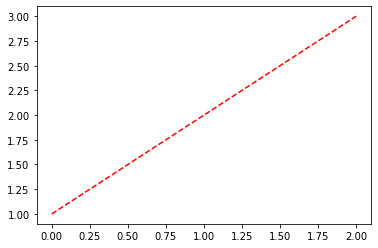

In [8]:
import matplotlib.pyplot as plt
losses=[1,2,3]
def my_plot_save(data_series,save_name,decor='r--'):
  t = range(0, len(data_series))
  plt.plot(t, data_series, decor)
  plt.savefig(save_name) #"/content/foo.png"
  plt.show()
my_plot_save(losses,"train.png")

#Data

In [0]:
hakuzari="/gdrive/My Drive/thesis-data/for_ctc_train22_FRIDBERG3.txt"
haemunot="/gdrive/My Drive/thesis-data/haemunot_vedeot/for_ctc_train22_FRIDBERG5.txt"
kfir_kuzari_test="/gdrive/My Drive/thesis-data/kfir1/kfir_kuzari_test.txt"
kfir_rasag_test="/gdrive/My Drive/thesis-data/kfir1/kfir_rasag_test.txt"

def load_lines(input_file=hakuzari):
  with open(input_file, 'rb') as f:
    text = f.read().decode(encoding='utf-8')
    text=text.replace('ֿ',"'")   ##I ADDED THIS. than did the replacement in the file uploaded to drive
    text=text.replace("&nbsp","")
  lines=text.strip().split('\n') 
  print(lines)
  print(len(lines)) # 10923 kuzari 10358 haemunot
  return lines

#lines=load_lines(haemunot)


###letter mapping

In [10]:
#all letters



#arab_letters="آأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىي" 
#heb_by_order="אאואיאבה'תת'ג'חכ'דד'רזסשצצ'טט'עגפקכלמנהויי"
#TODO EDIT: simple map will take first char in maped list for each hebrew letter


tag="'"
additional_letters=".H,?:;[]()!-\" 0123456789"


letter_dict={   #make sure all are here
    "א": "اإآأ", # mising alif wasla  
    "ב":"ب" ,
    "ג":"غ",
    "ג"+tag:"ج",
    "ד":"د",
    "ד"+tag:"ذ",
    "ה":"ه",
    "ה"+tag:"ة",
    "ו":"وؤ",
    "ז":"ز",
    "ח":"ح",
    "ט":"ط",
    "ט"+tag:"ظ",
    "י":"يىئ",
    "כ":"ك",
    "כ"+tag:"خ",
    "ל":"ل",
    "מ":"م",
    "נ":"ن",
    "ס":"س",
    "ע":"ع",
    "פ":"ف",
    "צ":"ص",
    "צ"+tag:"ض",
    "ק":"ق",
    "ר":"ر",
    "ש":"ش",
    "ת":"ت",
    "ת"+tag:"ث",
}

for i in additional_letters:
  letter_dict[i]=i

arab_heb_maping={}
heb_arab_maping={}
for heb,arr in letter_dict.items():
  heb_arab_maping[heb]=arr[0]
  for a in arr:
    arab_heb_maping[a]=heb


print(len(arab_heb_maping))
print(arab_heb_maping)
print(len(heb_arab_maping))
print(heb_arab_maping)



# arab_letters+=additional_letters
# heb_by_order+=additional_letters


# heb_by_order_tag=[]
# iterator = iter(range(len(heb_by_order)))

# for i in iterator:
#   if i+1!=len(heb_by_order) and heb_by_order[i+1]==tag:
#     heb_by_order_tag.append(heb_by_order[i]+tag)
#     next(iterator, None)
#   else:
#     heb_by_order_tag.append(heb_by_order[i])

# len(arab_letters)


# arab_heb_maping=dict(zip(arab_letters,heb_by_order_tag))

# print(len(arab_heb_maping))
# print(arab_heb_maping)

59
{'ا': 'א', 'إ': 'א', 'آ': 'א', 'أ': 'א', 'ب': 'ב', 'غ': 'ג', 'ج': "ג'", 'د': 'ד', 'ذ': "ד'", 'ه': 'ה', 'ة': "ה'", 'و': 'ו', 'ؤ': 'ו', 'ز': 'ז', 'ح': 'ח', 'ط': 'ט', 'ظ': "ט'", 'ي': 'י', 'ى': 'י', 'ئ': 'י', 'ك': 'כ', 'خ': "כ'", 'ل': 'ל', 'م': 'מ', 'ن': 'נ', 'س': 'ס', 'ع': 'ע', 'ف': 'פ', 'ص': 'צ', 'ض': "צ'", 'ق': 'ק', 'ر': 'ר', 'ش': 'ש', 'ت': 'ת', 'ث': "ת'", '.': '.', 'H': 'H', ',': ',', '?': '?', ':': ':', ';': ';', '[': '[', ']': ']', '(': '(', ')': ')', '!': '!', '-': '-', '"': '"', ' ': ' ', '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9'}
53
{'א': 'ا', 'ב': 'ب', 'ג': 'غ', "ג'": 'ج', 'ד': 'د', "ד'": 'ذ', 'ה': 'ه', "ה'": 'ة', 'ו': 'و', 'ז': 'ز', 'ח': 'ح', 'ט': 'ط', "ט'": 'ظ', 'י': 'ي', 'כ': 'ك', "כ'": 'خ', 'ל': 'ل', 'מ': 'م', 'נ': 'ن', 'ס': 'س', 'ע': 'ع', 'פ': 'ف', 'צ': 'ص', "צ'": 'ض', 'ק': 'ق', 'ר': 'ر', 'ש': 'ش', 'ת': 'ت', "ת'": 'ث', '.': '.', 'H': 'H', ',': ',', '?': '?', ':': ':', ';': ';', '[': '[', ']': ']', '(': '(', ')': ')'

In [0]:
##TODO need to edit this. this is for baseline

def simple_letter_map(heb_str): 
  res=[]
  tag="'"
  iterator = iter(range(len(heb_str)))
  for i in iterator:
    if i+1!=len(heb_str) and heb_str[i+1]==tag:     
      if heb_str[i]+tag in heb_arab_maping:
        ar_leter=heb_arab_maping[heb_str[i]+tag]
        res.append(ar_leter)
      else:
        ar_leter=heb_arab_maping[heb_str[i]]
        res.append(ar_leter)
        res.append(tag)
      next(iterator, None)
    else:      
      ar_leter=heb_arab_maping[heb_str[i]]
      res.append(ar_leter)
  return "".join(res)     


##preprocess sentences

In [0]:
import unicodedata

def unicode_to_ascii(s):
    s = s.rstrip().strip()#.translate(str.maketrans('', '', "!#$%&()*+,-./:;<=>?@[\]^_`{|}~"))
    return ''.join(c for c in unicodedata.normalize('NFC', s))
        #if unicodedata.category(c) != 'Mn')

def remove_arab_nikud(s):
  return ''.join(c for c in  s  if c not in arab_nikud)

def standard_nunization(s):
  return s.replace("ًا","اً")

arr="بأفراد كانوا لباباً "
assert(standard_nunization("بيتًا")=="بيتاً")


def preprocess_hebrew(w):
    w = unicode_to_ascii(w.strip())    
    w = w.replace('ם','מ').replace('ן','נ').replace('ץ','צ').replace('ף','פ').replace('ך','כ')
    w = w.replace('ֿ',"'")
    return w

def double_hebrew(w):    
    res=""
    for i in w:
      res+=i
      if not i==" ":  ##THIS 2 LINES IS THE CHANGE THAT WAS ADDED AT THE LAST MINUTE 
        res+=i    
    return res

#    Takes a file of <heb, arab> phrases separated by tab
#    Return phares pairs in the format: [ENGLISH, SPANISH]
def create_dataset(lines,num_examples=200000000):
    word_pairs=[]
    for l in lines[:num_examples]:
      splited=l.split('\t')
      heb=splited[0]
      heb=unicode_to_ascii(heb)
      heb=preprocess_hebrew(heb)
      heb=double_hebrew(heb)
      heb=clear_blank(clear_arab_punctuation(heb))
      arr=splited[1]
      arr=remove_arab_nikud(arr)
      arr=standard_nunization(arr)
      arr=clear_blank(clear_arab_punctuation(arr))
      arr=unicode_to_ascii(arr) 
      word_pairs.append([heb,arr])        
    return word_pairs


small example for demonstration

In [13]:
this_string='وأهل الأديان ثمّ على'
this_string='سُئِلْتُ عمّا عنديَ من الاحتجاج'
#this_string='كان عند مَلِك الخَزَرِ الداخل'
print(len(this_string))
this_string=unicode_to_ascii(remove_arab_nikud(this_string)) #new!!!!

print(len(this_string))
this_string

31
26


'سئلت عمّا عندي من الاحتجاج'

languageIndex class

In [0]:
###ALTERNATIVE language index

# This class creates a char -> index mapping (e.g,. "d" -> 5) and vice-versa 
# (e.g., 5 -> "d") for each language,

#this class takes a corpus of lines (lang) and extract the vocab
# (letters and signs), stores the corpus and the vocab (with revers map)
# it also addes the BLANK symbol to the vocab. (makes sure that BLANK is not in the corpus)
BLANK="_"
class LanguageIndex():
  def __init__(self, allowed_letters):
    self.allowed_letters = allowed_letters
    self.char2idx = {}
    self.idx2char = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for c in self.allowed_letters:
      #for c in phrase:     #for the meantime don't habdle the diatrics in- hebrew (the tag) and hope the ctc will handle...wishfully
        self.vocab.update(c)
      #for c in additional_letters:
      #  self.vocab.update(c)
    self.vocab = sorted(self.vocab)
    print("vocab: ",self.vocab)   # maps id (i.e. map index) to char
    
    
    for index, char in enumerate(self.vocab): #reverse map: char to id
      self.char2idx[char] = index
    print("len(self.vocab)",len(self.vocab))
    assert(BLANK not in self.char2idx)
    self.char2idx[BLANK] = len(self.vocab)   #add BLANK to reverse map
    print("len(self.char2idx)",len(self.char2idx)) #should print successor of privous print
    print(self.char2idx[BLANK],BLANK)
    
    
    for char, index in self.char2idx.items():  #this is a map equal to the array vocab, but with BLANK
      self.idx2char[index] = char

load_dataset method

In [15]:

def max_length(tensor):
    return max(len(t) for t in tensor)

#inp_lang = LanguageIndex(heb_by_order)
inp_lang = LanguageIndex("".join(heb_arab_maping.keys()))
#targ_lang = LanguageIndex(arab_letters+u"\u0651"+"".join(tanween)+ u"\u0621")# shadda and hamza on line  (arab_nikud)
targ_lang = LanguageIndex("".join(arab_heb_maping.keys())+"".join(tanween)+ shada + hamza_on_line)


def load_dataset(pairs):
    # creating cleaned input, output pairs    
   # pairs = create_dataset(lines,num_examples)  
  
    input_tensor = [vectorize(heb,inp_lang.char2idx) for heb, arr in pairs]
    input_lenghts=[len(heb) for heb,arr in pairs]
    # English sentences
    target_tensor = [vectorize(arr,targ_lang.char2idx) for heb, arr in pairs]
    target_lengths = [len(arr)  for heb,arr in pairs]
    print()
    print(LTRchar,pairs[0])
    print(input_lenghts[0])
    print(target_lengths[0])
    print(input_tensor[0])
    print(target_tensor[0])

    # Padding the input and output tensor to the maximum length
    max=max_length(input_tensor)
    if max>70:
      max=70
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max,
                                                                 padding='post',
                                                                  value=inp_lang.char2idx[BLANK])
    max=max_length(target_tensor)
    if max>70:
      max=70    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max,
                                                                  padding='post',
                                                                  value=targ_lang.char2idx[BLANK])
    
    print()
    print(LTRchar,pairs[0])
    print(input_lenghts[0])
    print(target_lengths[0])
    print(input_tensor[0])
    print(len(input_tensor[0]))
    print(target_tensor[0])
    print(len(target_tensor[0]))

    return input_tensor, target_tensor ,input_lenghts,target_lengths

vocab:  [' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'H', '[', ']', 'א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'כ', 'ל', 'מ', 'נ', 'ס', 'ע', 'פ', 'צ', 'ק', 'ר', 'ש', 'ת']
len(self.vocab) 47
len(self.char2idx) 48
47 _
vocab:  [' ', '!', '"', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'H', '[', ']', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ً', 'ٌ', 'ٍ', 'ّ']
len(self.vocab) 64
len(self.char2idx) 65
64 _


call load_dataset

In [16]:
lines=load_lines()
#num_examples = 2000000000  #don't limit
pairs = create_dataset(lines)  
input_tensor, target_tensor ,input_lenghts,target_lengths = load_dataset(pairs)
lines=load_lines(haemunot)
pairs = create_dataset(lines)  
input_tensor1, target_tensor1 ,input_lenghts1,target_lengths1 = load_dataset(pairs)


FileNotFoundError: ignored

In [0]:

# lines=load_lines(kfir_kuzari_test)
# pairs = create_dataset(lines)  
# input_tensor3, target_tensor3 ,input_lenghts3,target_lengths3 = load_dataset(pairs)

# lines=load_lines(kfir_rasag_test)
# pairs = create_dataset(lines)  
# input_tensor4, target_tensor4 ,input_lenghts4,target_lengths4 = load_dataset(pairs)



generate the data tensor

In [0]:
def gen_data(input_tensor, target_tensor,input_lenghts,target_lengths,_test_size=0.2):
  if _test_size<1:
    input_tensor_train, input_tensor_val, \
    target_tensor_train, target_tensor_val, \
    input_lengths_train, input_lengths_val, \
    target_lengths_train, target_lengths_val = train_test_split(input_tensor,
                                                                target_tensor,
                                                                input_lenghts,
                                                                target_lengths, test_size=_test_size)
    print(len(input_tensor_train), 
          len(target_tensor_train), 
          len(input_tensor_val), 
          len(target_tensor_val))
    
    BUFFER_SIZE = len(input_tensor_train)
    #N_BATCH = BUFFER_SIZE//BATCH_SIZE
    #vocab_inp_size = len(inp_lang.char2idx)
    #vocab_tar_size = len(targ_lang.char2idx)


    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                                  target_tensor_train,
                                                  input_lengths_train,
                                                  target_lengths_train)).shuffle(BUFFER_SIZE)


    test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, 
                                                      target_tensor_val,
                                                      input_lengths_val,
                                                      target_lengths_val)).shuffle(BUFFER_SIZE)                                                  
    
    dataset_double=dataset.batch(BATCH_SIZE, drop_remainder=True)
  else:
    print(len(input_tensor), 
          len(target_tensor))
    
    
    BUFFER_SIZE = len(input_tensor)
    test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor,
                                                       target_tensor,
                                                       input_lenghts,
                                                       target_lengths)).shuffle(BUFFER_SIZE)                                                  
    dataset_double=0
  test_dataset_double=test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return dataset_double,test_dataset_double



##activate gen data

In [0]:
#ACTIVATE
dataset_double,test_dataset_double=gen_data(input_tensor, target_tensor,input_lenghts,target_lengths)
view_data(test_dataset_double)
dataset_double1,test_dataset_double1=gen_data(input_tensor1, target_tensor1,input_lenghts1,target_lengths1)
view_data(test_dataset_double1)

# _,test_dataset_double3=gen_data(input_tensor3, target_tensor3,input_lenghts3,target_lengths3,_test_size=1)
# view_data(test_dataset_double3)
# _,test_dataset_double4=gen_data(input_tensor4, target_tensor4,input_lenghts4,target_lengths4,_test_size=1)
# view_data(test_dataset_double4)

##Shuffled test

In [0]:
def get_shuffled_word_pairs(test_dataset):
  
  val_inputs_list=[]
  val_outputs_list=[]

  for i,j,l1,l2 in test_dataset:
    for tt in range(BATCH_SIZE):
     # print(i[tt],j[tt])
      i_prediction=print_by_idx_CTC(tf.constant(i[tt]),inp_lang.idx2char,l1[tt])
      j_prediction=print_by_idx_CTC(tf.constant(j[tt]),targ_lang.idx2char,l2[tt])      
      if (len(i_prediction.split())==len(j_prediction.split())):
        val_inputs_list+=i_prediction.split()
        val_outputs_list+=j_prediction.split()
    
  print("len(val_inputs_list),len(val_outputs_list)",len(val_inputs_list),len(val_outputs_list)) #10836 10836

  word_pairs=list(zip(val_inputs_list,val_outputs_list))
  print("BEFORE SHUFFLE")
  for i in word_pairs[:5]:
    print(i)
  random.shuffle(word_pairs)
  print("AFTER SHUFFLE")
  for i in word_pairs[:5]:
    print(i)
  return word_pairs

#TESTING
#word_pairs1=get_shuffled_word_pairs(test_dataset_double1.take(1))


In [0]:
def get_shuffled_data(word_pairs):

  accum=0
  heb_acum=""
  arab_acum=""
  results_line=[]
  for i,j in word_pairs:
    if accum>19:
      results_line.append(un_double_letters(heb_acum)+'\t'+arab_acum)
      assert(len(i)%2==0)
      accum=len(i)/2
      heb_acum=i
      arab_acum=j
    else:
      heb_acum+=" "+i
      arab_acum+=" "+j 
      assert(len(i)%2==0)
      accum += len(i)/2 + 1;
  results_line.append(heb_acum+'\t'+arab_acum)  #needed?

  print("len(results_line)",len(results_line)) # 2175 before was: 2185 lines 


  input_tensor_shuffle, target_tensor_shuffle \
  ,input_lenghts_shuffle,target_lengths_shuffle = load_dataset(create_dataset(results_line))

  print("len(input_tensor_shuffle), len(input_lenghts_shuffle)",len(input_tensor_shuffle), len(input_lenghts_shuffle))
  print("len(target_tensor_shuffle),  len(target_lengths_shuffle)",len(target_tensor_shuffle), len(target_lengths_shuffle))

  BUFFER_SIZE = len(target_lengths_shuffle)

  shuffle_test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_shuffle,
                                                            target_tensor_shuffle,
                                                            input_lenghts_shuffle,
                                                            target_lengths_shuffle)).shuffle(BUFFER_SIZE)

  shuffle_test_dataset_double=shuffle_test_dataset.batch(BATCH_SIZE, drop_remainder=True)
  return shuffle_test_dataset_double



In [0]:
#ACTIVATE
word_pairs=get_shuffled_word_pairs(test_dataset_double)
shuffle_test_dataset_double=get_shuffled_data(word_pairs)
view_data(shuffle_test_dataset_double)


word_pairs1=get_shuffled_word_pairs(test_dataset_double1)
shuffle_test_dataset_double1=get_shuffled_data(word_pairs1)
view_data(shuffle_test_dataset_double1)





##Single words test

In [0]:
results_line=[]
for i,j in word_pairs:
    results_line.append(un_double_letters(i)+'\t'+j)

print("len(results_line)",len(results_line)) 


input_tensor_shuffle, target_tensor_shuffle \
, input_lenghts_shuffle,target_lengths_shuffle = load_dataset(create_dataset(results_line))

print("len(input_tensor_shuffle), len(target_tensor_shuffle), len(input_lenghts_shuffle), len(target_lengths_shuffle)",len(input_tensor_shuffle), len(target_tensor_shuffle), len(input_lenghts_shuffle), len(target_lengths_shuffle))

BUFFER_SIZE = len(target_lengths_shuffle)

single_words_test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_shuffle,
                                                                target_tensor_shuffle,
                                                                input_lenghts_shuffle,
                                                                target_lengths_shuffle)).shuffle(BUFFER_SIZE)

single_words_test_dataset=single_words_test_dataset.batch(BATCH_SIZE, drop_remainder=True)

view_data(single_words_test_dataset)

##SYNTHETIC DATA

In [0]:
#TODO edit when time permits

def load_text_for_synth(ibnsina="/gdrive/My Drive/JUDEO-ARAB/ibn_sina_ilhyat.txt"):
  with open(ibnsina, 'rb') as f:
      ibnsina_text = f.read().decode(encoding='utf-8')


  ibnsina_text=clear_arab_punctuation(ibnsina_text)
  #TODO somthing with new line - this indicates new content!!!

  #add space before and after punctuation signs
  import re
  ibnsina_text = re.sub(r"([:;?.!,¿])", r" \1 ", ibnsina_text)
  ibnsina_text = re.sub(r'[" "]+', " ", ibnsina_text)    
  
  return ibnsina_text


#ACTIVATE
ibnsina_text=load_text_for_synth()

In [0]:
ibnsina_text[:250]


In [0]:
#STATSTICS OF SYNTH TEXT
sina_vocab=sorted(set(ibnsina_text))

print("NOT IN LETTER LIST:")
for c in sina_vocab:
   if c not in targ_lang.char2idx:
      print("(",c,")")

print("\nLETTER COUNTS")
for i in range(len(sina_vocab)):
  print(LTRchar,i,'"',sina_vocab[i],'"',ibnsina_text.count(sina_vocab[i])) #64 is shadda   

In [0]:
#ibnsina_text=ibnsina_text.replace("\r\n\r\n","\r\n").replace("\r\n"," \r\n ") #TODO rethink this
#sina_words=ibnsina_text.split(" ")
#ibnsina_text=ibnsina_text.replace("\r\n\r\n","\r\n").replace("\r\n",". ") #TODO rethink this
sina_words=ibnsina_text.split() #for removing also newlines
print(ibnsina_text[:100])
sina_words[0:10]

In [0]:
def gen_synth_sentences(sina_words):

  #SENTENCE_LIMIT=random.randint(1,50) #this didn't work. try random with range1,10
  SENTENCE_LIMIT=20
  sentences=[]
  char_count=0
  res=[]
  for w in sina_words:
  #  w=w.rstrip(" ").strip(" ")
    char_count+=len(w)+1 #len of word + space afterwards
    res.append(w)
    if char_count>SENTENCE_LIMIT:    
      sentences.append(unicode_to_ascii(remove_arab_nikud(" ".join(res))))
      res=[]
      char_count=0
    #  SENTENCE_LIMIT=random.randint(1,50)          
  return sentences

#ACTIVATE
sentences=gen_synth_sentences(sina_words)
len(sentences)
sentences[:5]


In [0]:
# arab_setences=[]
# heb_sentences=[]

def gen_dropout(sentences,keep_prob=0.90):
  arab_setences=[]
  heb_sentences=[]
  for arr in sentences:
    arab_setences.append(arr)        
    heb=[]
    for c in arr:
      if c in arab_heb_maping:
        if (np.random.binomial(1,keep_prob)) or c==" ":
          heb.append(arab_heb_maping[c])
        else:
          heb.append(BLANK)

    #print("".join(heb))
    heb_sentences.append(double_hebrew(preprocess_hebrew("".join(heb))))

  print(heb_sentences[:5]) 
  print(arab_setences[:5])

  print(len(arab_setences))
  input_tensor_synth, target_tensor_synth, \
  input_lenghts_synth,target_lengths_synth = load_dataset(list(zip(heb_sentences,arab_setences)))
  
  # Show length
  print(len(input_tensor_synth), len(target_tensor_synth))
  print(len(input_lenghts_synth), len(target_lengths_synth))

  BUFFER_SIZE = len(input_tensor_synth)

  dataset_synth = tf.data.Dataset.from_tensor_slices((input_tensor_synth,
                                                      target_tensor_synth,
                                                      input_lenghts_synth,
                                                      target_lengths_synth)).shuffle(BUFFER_SIZE)


  dataset_double_synt=dataset_synth.batch(BATCH_SIZE, drop_remainder=True)
  #dataset_double_synt=dataset_double_synt.concatenate(dataset_double).shuffle(BUFFER_SIZE)
  return dataset_double_synt



In [0]:
# # def remove_chars_not_in_dict(s,dict):
# #   #print(s)
# #   res=''
# #   for c in s:
# #     if c in dict:
# #       res+=c
# #   return res

# def print_show(i):
#     print(len(heb_sentences),len(arab_setences))
#     print(heb_sentences[i],arab_setences[i])
#     print(input_lenghts[i])
#     print(target_lengths[i])
#     print(input_tensor[i])
#     print(target_tensor[i])


# def load_dataset_synth(arab_setences,heb_sentences):
#     # creating cleaned input, output pairs    
#     print(heb_sentences[0])
#     input_tensor = [vectorize(heb,inp_lang.char2idx) for heb in heb_sentences]
#     print(input_tensor[0])
#     input_lenghts=[len(heb) for heb in heb_sentences]
  
#     target_tensor = [vectorize(arr,targ_lang.char2idx) for arr in arab_setences]
#     target_lengths = [len(arr)  for  arr in arab_setences]
#     print(len(arab_setences))
#     print(len(target_tensor))

#     # Padding the input and output tensor to the maximum length
#     input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
#                                                                  maxlen=max_length(input_tensor),
#                                                                  padding='post',
#                                                                   value=inp_lang.char2idx[BLANK])
    
#     target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
#                                                                   maxlen=max_length(target_tensor), 
#                                                                   padding='post',
#                                                                   value=targ_lang.char2idx[BLANK])
#     print(len(target_tensor))
#    # print_show(0)

#     return input_tensor, target_tensor , input_lenghts,target_lengths


In [0]:
def gen_dropout_all(keep=1):
  synth_text=load_text_for_synth()
  sentences=gen_synth_sentences(synth_text.split())
  dataset_double_synt=gen_dropout(sentences,keep)

  path1="/gdrive/My Drive/JUDEO-ARAB/daruri-IR.txt"
  synth_text1=load_text_for_synth(path1)
  sentences1=gen_synth_sentences(synth_text1.split())
  dataset_double_synt1=gen_dropout(sentences1,keep).concatenate(dataset_double_synt)

  path2="/gdrive/My Drive/JUDEO-ARAB/farabi-tahsil.txt"
  synth_text2=load_text_for_synth(path2)
  sentences2=gen_synth_sentences(synth_text2.split())
  dataset_double_synt2=gen_dropout(sentences2,keep).concatenate(dataset_double_synt1)


  path3="/gdrive/My Drive/JUDEO-ARAB/huruf.txt"
  synth_text3=load_text_for_synth(path3)
  sentences3=gen_synth_sentences(synth_text3.split())
  dataset_double_synt3=gen_dropout(sentences2,keep).concatenate(dataset_double_synt2)


  return dataset_double_synt3.concatenate(dataset_double).shuffle(BUFFER_SIZE)
view_data(gen_dropout_all())

#MODEL

In [0]:
#NETWORK PARAMS
# The embedding dimension
embedding_dim = 8 #256

# Number of RNN units
rnn_units = 1024 #1024


if tf.test.is_gpu_available():
  #rnn = tf.keras.layers.CuDNNGRU
  rnn=tf.compat.v1.keras.layers.CuDNNGRU
  #rnn = tf.keras.layers.LSTM #see https://stackoverflow.com/questions/55761337/module-tensorflow-python-keras-api-v2-keras-layers-has-no-attribute-cudnnlst

else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')
  
#FUNCTION TO BUILD MODEL
def build_model(vocab_size_heb1,vocab_size_ar, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_heb1, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.Bidirectional(rnn(rnn_units,     #I added the bidirectianl myself on top of https://www.tensorflow.org/tutorials/sequences/text_generation. this improve the results because the net can predict end of word, and know when to put OTIOT SOFIOT 
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True)),

   tf.keras.layers.Bidirectional(rnn(rnn_units,     #I added the bidirectianl myself on top of https://www.tensorflow.org/tutorials/sequences/text_generation. this improve the results because the net can predict end of word, and know when to put OTIOT SOFIOT 
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True)),
   tf.keras.layers.Bidirectional(rnn(rnn_units,     #I added the bidirectianl myself on top of https://www.tensorflow.org/tutorials/sequences/text_generation. this improve the results because the net can predict end of word, and know when to put OTIOT SOFIOT 
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True)),
    
  

    tf.keras.layers.Bidirectional(rnn(rnn_units,     #I added the bidirectianl myself on top of https://www.tensorflow.org/tutorials/sequences/text_generation
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True)),
    tf.keras.layers.Dense(vocab_size_ar
                         )
  ])
  return model

In [0]:
def rebuild():
  #BUILD MODEL
  model = build_model(
    vocab_size_ar = len(targ_lang.char2idx),
    vocab_size_heb1 = len(inp_lang.char2idx),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE,
    )

  model.summary()
  return model
model=rebuild()

#TESTING FUNCTIONS

In [0]:
from termcolor import colored
import difflib

def show_diff(t1,t2,col):
    """Unify operations between two compared strings
seqm is a difflib.SequenceMatcher instance whose a & b are strings"""
    seqm= difflib.SequenceMatcher(None,t1,t2)   
    output1=[]
    output2= []
    for opcode, a0, a1, b0, b1 in seqm.get_opcodes():
        
        if opcode == 'equal':            
            output1.append(seqm.a[a0:a1])
            output2.append(seqm.b[b0:b1])
        elif opcode == 'insert':            
            output2.append(colored(seqm.b[b0:b1],col,attrs=['bold']))
        elif opcode == 'delete':
            output1.append(colored(seqm.a[a0:a1],col,attrs=['bold']))
        elif opcode == 'replace':            
            output1.append(colored(seqm.a[a0:a1],col,attrs=['bold']))
            output2.append(colored(seqm.b[b0:b1],col,attrs=['bold']))
        else:
            raise RuntimeError("unexpected opcode")
    return ''.join(output1),''.join(output2)

#USEAGE:
s1="لامة النصارى واستحقو" 
s2="لأمّة النصارى واستحقوّا"
a,b=show_diff(s1,s2,'blue')
#print("".join(b))
print(a,"|",b)

#print('\x1b[31mّ\x1b[0m')


## forward run each letter seperatly

In [0]:
def test__CTC_letters(): 
  total_accuracy=0
  total_examples=0

  all_heb_letters=inp_lang.vocab
  
  num_of_letters=len(inp_lang.vocab)
  num_of_arab_letters=len(targ_lang.vocab)

#  print(num_of_letters)
  letters_as_int=[]
  tag=inp_lang.char2idx["'"]
  for t in range(num_of_letters):
    letters_as_int.append([t]*2)
  for t in range(BATCH_SIZE-num_of_letters):
    letters_as_int.append([0,0])    

  letters_tensor=tf.convert_to_tensor(letters_as_int)
  
  predict_ltrs=model(letters_tensor)
  
  
  for jj in range(num_of_letters):
      print("candidate:***({0})***".format(inp_lang.vocab[jj]))
      
      pred_distr=predict_ltrs[jj][1]
      pred_distr=tf.nn.softmax(pred_distr)
      for ii in range(num_of_arab_letters):
       print("{0:.3f}({1})  ".format(pred_distr[ii],targ_lang.vocab[ii]),end = '')
      print("{0:.3f} <blank>".format(pred_distr[num_of_arab_letters]))
      maximum=tf.argmax(pred_distr).numpy()
      max_score=tf.math.reduce_max(pred_distr).numpy()
      if (maximum<num_of_arab_letters):
        print("prediction***({0})***{1:.3f}".format(targ_lang.vocab[maximum],max_score))
      else:
        print("####max is the blank symbole")
      print('-'*10)
  
#test__CTC_letters()

##forward run a sentence (with top n beam search results)

In [0]:
#TODO edit code when time permits

def test__CTC_word_multiline(word_str,num_of_paths=5,_BATCH_SIZE=BATCH_SIZE,print_deteils=False): 
  lines=word_str.split('\n')
  num_of_lines=len(lines)
  assert(num_of_lines<=BATCH_SIZE)

  inputs=[]
  inputs_len=[]
  for l in lines:
    l = preprocess_hebrew(l)
    l = double_hebrew(l)
    v=vectorize(l,inp_lang.char2idx)
    inputs.append(v)
    inputs_len.append(len(v))
  #max_len=max_len(inputs)
  #PADD HORIZANTALY
  for i in range(BATCH_SIZE-num_of_lines):
    inputs.append([0])
    inputs_len.append(1)



  res=[]
#  inp=[] 
#  double=[]
  #num_of_letters=0
  #for c in word_str:
  #  double.append(inp_lang.char2idx[c])
  #  num_of_letters+=1
  #  if not c==' ':
  #    double.append(inp_lang.char2idx[c])
  #    num_of_letters+=1
  #inp.append(double)
  #inp.append([inp_lang.char2idx[c] for c in word_str])
  #for i in range(_BATCH_SIZE-1):
  #  inp.append([0]*num_of_letters)
  
 # num_of_arab_letters=len(targ_lang.vocab)

  #print(num_of_letters)

  #PADDDDDD
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, 
                                                         maxlen=max_length(inputs),
                                                         padding='post',
                                                         value=inp_lang.char2idx[BLANK])
    
  inputs=tf.convert_to_tensor(inputs)
    
  predict_ltrs=model(inputs)
  #print(predict_ltrs.shape)
  
  
  #inputs_len=[num_of_letters]*_BATCH_SIZE
  inputs=tf.transpose(predict_ltrs,perm=[1,0,2]) #[max_time, batch_size, num_classes]
  
  #decoded, log_probabilities=tf.nn.ctc_beam_search_decoder_v2(
  decoded, log_probabilities=tf.nn.ctc_beam_search_decoder(
                      inputs,
                      inputs_len,top_paths=num_of_paths) 
  # if print_deteils:
  #   print('#####deteils')
  # for jj in range(num_of_letters):
  #     if print_deteils:
  #       print(word_str[jj])
      
  #     pred_distr=predict_ltrs[0][jj]
  #     pred_distr=tf.nn.softmax(pred_distr)
  #     if print_deteils:
  #       for ii in range(num_of_arab_letters):
  #         print("{0:.3f}".format(pred_distr[ii]),targ_lang.vocab[ii])
  #       print("{0:.3f} <blank>".format(pred_distr[num_of_arab_letters]))
  #       print()
  #     maximum=tf.argmax(predict_ltrs[0][jj]).numpy()
  #     if print_deteils:
  #       print(maximum)
  #     if (maximum<42):
  #       if print_deteils:
  #         print(targ_lang.vocab[maximum])
  #       res.append(targ_lang.vocab[maximum])
  #     else:
  #       if print_deteils:
  #         print("####max is the blank symbole")
  #       res.append("-")
  #     if print_deteils:
  #       print('-'*10)
  # print(word_str)
  #print("ARGMAX PREDICTION: ","".join(res))  
  total_res=""
  for t in range(num_of_lines):
    print(lines[t])
    for i in reversed(range(num_of_paths)):
      dense=tf.sparse.to_dense(decoded[i])   
      prediction=print_by_idx_CTC(dense[t],targ_lang.idx2char)
      print("#####PREDICTION"+str(i)+": ",prediction)
    total_res+='\n'+prediction
  return total_res
  
#IMPORTED OBSERV: it seems that ctc decodes make much more than just argmax over sequences see https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7
###  ا-ل-ط-ب-ي-ع-ي-ة  و-ك-ا-ل-اا   -م---ع-ع-ا-ا   ---> الطبيعية كمالاً مستعدّاً


lines='''כמאלא
כמאלא'''

print(test__CTC_word_multiline(lines,3,BATCH_SIZE))

###test kfir

In [0]:
import editdistance
#TODO edit code when time permits

def test__CTC_word_multiline_kfir(word_str,targ_str,num_of_paths=1,_BATCH_SIZE=BATCH_SIZE,SHOW_PRINT=False): 
  lines=word_str.split('\n')
  targ_lines=targ_str.split('\n')
  num_of_lines=len(lines)
  assert(num_of_lines==len(targ_lines))
  assert(num_of_lines<=BATCH_SIZE)

  inputs=[]
  inputs_len=[]
  for l in lines:
    l = preprocess_hebrew(l)
    #l = double_hebrew(l)
    v=vectorize(l,inp_lang.char2idx)
    inputs.append(v)
    inputs_len.append(len(v))
  #max_len=max_len(inputs)
  #PADD HORIZANTALY
  for i in range(BATCH_SIZE-num_of_lines):
    inputs.append([0])
    inputs_len.append(1)



  res=[]
#  inp=[] 
#  double=[]
  #num_of_letters=0
  #for c in word_str:
  #  double.append(inp_lang.char2idx[c])
  #  num_of_letters+=1
  #  if not c==' ':
  #    double.append(inp_lang.char2idx[c])
  #    num_of_letters+=1
  #inp.append(double)
  #inp.append([inp_lang.char2idx[c] for c in word_str])
  #for i in range(_BATCH_SIZE-1):
  #  inp.append([0]*num_of_letters)
  
 # num_of_arab_letters=len(targ_lang.vocab)

  #print(num_of_letters)

  #PADDDDDD
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, 
                                                         maxlen=max_length(inputs),
                                                         padding='post',
                                                         value=inp_lang.char2idx[BLANK])
    
  inputs=tf.convert_to_tensor(inputs)
    
  predict_ltrs=model(inputs)
  
  
  
  
  inputs=tf.transpose(predict_ltrs,perm=[1,0,2]) #[max_time, batch_size, num_classes]
  
  
  decoded, log_probabilities=tf.nn.ctc_beam_search_decoder(
                      inputs,
                      inputs_len,top_paths=num_of_paths) 
  
  total_res=[]
  total_edit_dist=0
  line_counter=1
  for t in range(num_of_lines):
    #print(lines[t])
    # print("real:",targ_lines[t])
    for i in reversed(range(num_of_paths)):
      dense=tf.sparse.to_dense(decoded[i])   
      prediction=print_by_idx_CTC(dense[t],targ_lang.idx2char).strip() 
      # print("#####PREDICTION"+str(i)+": ",prediction)
      total_res.append(prediction)
    # print(len(prediction))
    #print(len(targ_lines[t]))
    ed_dist=editdistance.eval(targ_lines[t], prediction)
    # print("edit_dist:",ed_dist)
    ed_dist/=len(targ_lines[t])
    real,prediction=show_diff(targ_lines[t],prediction,'red')
    if SHOW_PRINT:
      print("({0})".format(line_counter),LTRchar,un_double_letters(lines[t]),"|",real,"|",prediction,"|","{0:.4f}".format(ed_dist))
    line_counter+=1


    total_edit_dist+=ed_dist
  return total_res,total_edit_dist,num_of_lines
  
#IMPORTED OBSERV: it seems that ctc decodes make much more than just argmax over sequences see https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7
###  ا-ل-ط-ب-ي-ع-ي-ة  و-ك-ا-ل-اا   -م---ع-ع-ا-ا   ---> الطبيعية كمالاً مستعدّاً


lines='''יכ'אלף
עלי
הד'ה
אלאמאנה
ולא'''

lines='''ייככ''אאללףף
עעלליי
ההדד''הה
אאללאאממאאננהה
ווללאא'''

targ_lines='''يخالف
على
هذه
الأمانة
ولا'''

print(test__CTC_word_multiline_kfir(lines,targ_lines,1,BATCH_SIZE))

In [0]:
_#data_path options:
# kfir_kuzari_test
# kfir_rasag_test

#replace_GAIN - replace JAIN with GIMEL

def test_kfir(data_path,replace_GAIN=False,SHOW_PRINT=False):

  lines=load_lines(data_path)
  pairs = create_dataset(lines)  
  # #input_tensor4, target_tensor4 ,input_lenghts4,target_lengths4 = load_dataset(pairs)

  if replace_GAIN:
    hebrew_lines=[heb.replace("גג","גג''").replace("גג''''","גג") for heb, arr in pairs]
  else:
    hebrew_lines=[heb for heb, arr in pairs]
  arab_lines=[arr for heb, arr in pairs]

  num_of_lines=len(pairs)
  index=0
  total_num_of_examples=0
  total_sum_e_d=0
  while index<=num_of_lines:
    batch_hebrew=hebrew_lines[index:index+BATCH_SIZE]
    batch_arab=arab_lines[index:index+BATCH_SIZE]
    _,sum_of_e_d,num_of_examples=test__CTC_word_multiline_kfir('\n'.join(batch_hebrew),'\n'.join(batch_arab),1,BATCH_SIZE,SHOW_PRINT)
    if SHOW_PRINT:
      print("BATCH (sum_of_e_d,num_of_examples): ",sum_of_e_d,num_of_examples)
    total_num_of_examples+=num_of_examples
    total_sum_e_d+=sum_of_e_d
    index+=BATCH_SIZE

  print("total_num_of_examples:total_sum_e_d:ratio",total_num_of_examples,total_sum_e_d,1-total_sum_e_d/total_num_of_examples)
  return total_sum_e_d/total_num_of_examples

test_kfir(kfir_kuzari_test,True)
#test_kfir(kfir_kuzari_test)
test_kfir(kfir_rasag_test,True)

#test_kfir(kfir_rasag_test)

In [0]:
arr=[1,2,3,4]
arr[0:3]

In [0]:
pairs

In [0]:

# #TODO edit code when time permits

# def test__CTC_word(word_str,num_of_paths=5,_BATCH_SIZE=BATCH_SIZE,print_deteils=False): 
#   res=[]
#   inp=[] 
#   double=[] 
#   num_of_letters=0
#   for c in word_str:
#     double.append(inp_lang.char2idx[c])
#     num_of_letters+=1
#     if not c==' ':
#       double.append(inp_lang.char2idx[c])
#       num_of_letters+=1
#   inp.append(double)
#   #inp.append([inp_lang.char2idx[c] for c in word_str])
#   for i in range(_BATCH_SIZE-1):
#     inp.append([0]*num_of_letters)
  
#   num_of_arab_letters=len(targ_lang.vocab)

#   #print(num_of_letters)
  
#   letters_tensor=tf.convert_to_tensor(inp)
    
#   predict_ltrs=model(letters_tensor)
#   #print(predict_ltrs.shape)
  
  
#   inputs_len=[num_of_letters]*_BATCH_SIZE
#   inputs=tf.transpose(predict_ltrs,perm=[1,0,2]) #[max_time, batch_size, num_classes]
  
#   decoded, log_probabilities=tf.nn.ctc_beam_search_decoder_v2(
#                       inputs,
#                       inputs_len,top_paths=num_of_paths) 
#   if print_deteils:
#     print('#####deteils')
#   for jj in range(num_of_letters):
#       if print_deteils:
#         print(word_str[jj])
      
#       pred_distr=predict_ltrs[0][jj]
#       pred_distr=tf.nn.softmax(pred_distr)
#       if print_deteils:
#         for ii in range(num_of_arab_letters):
#           print("{0:.3f}".format(pred_distr[ii]),targ_lang.vocab[ii])
#         print("{0:.3f} <blank>".format(pred_distr[num_of_arab_letters]))
#         print()
#       maximum=tf.argmax(predict_ltrs[0][jj]).numpy()
#       if print_deteils:
#         print(maximum)
#       if (maximum<42):
#         if print_deteils:
#           print(targ_lang.vocab[maximum])
#         res.append(targ_lang.vocab[maximum])
#       else:
#         if print_deteils:
#           print("####max is the blank symbole")
#         res.append("-")
#       if print_deteils:
#         print('-'*10)
#   print(word_str)
#   print("ARGMAX PREDICTION: ","".join(res))  
#   for i in reversed(range(num_of_paths)):
#     dense=tf.sparse.to_dense(decoded[i])   
#     prediction=print_by_idx_CTC(dense[0],targ_lang.idx2char)
#     print("#####PREDICTION"+str(i)+": ",prediction)
#   return prediction
  
# #IMPORTED OBSERV: it seems that ctc decodes make much more than just argmax over sequences see https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7
# ###  ا-ل-ط-ب-ي-ع-ي-ة  و-ك-ا-ل-اا   -م---ع-ع-ا-ا   ---> الطبيعية كمالاً مستعدّاً

# #test__CTC_word("כמאלא",3,BATCH_SIZE)

##test baseline

In [0]:
import editdistance
def test_loss_baseline(this_dataset=test_dataset_double,only_first=True,limit=False):
  num_of_paths=1
  total_loss=0
  total_accuracy=0
  total_examples=0
  line_counter=1
  if limit:
    this_dataset=this_dataset.take(limit)
  for input_example_batch, target_example_batch, inputs_len,targets_len in this_dataset:
			
          for i in range(BATCH_SIZE):
                heb_input=print_by_idx_CTC(input_example_batch[i],inp_lang.idx2char)

                heb_input=un_double_letters(heb_input).strip(BLANK)
                prediction=simple_letter_map(heb_input)
                real=print_by_idx_CTC(target_example_batch[i],targ_lang.idx2char,targets_len[i].numpy()).strip(BLANK)  
                accuracy=editdistance.eval(real, prediction)
                accuracy/=len(real)
                total_accuracy+=accuracy
                if only_first and i!=0:
                    continue
                real,prediction=show_diff(real,prediction,'red')
                print("({0})".format(line_counter),LTRchar,heb_input.strip(BLANK),"|",real,"|",prediction,"|","{0:.4f}".format(accuracy))
                line_counter+=1
          total_examples+=BATCH_SIZE
							 
  if total_accuracy!=0:
    total_accuracy/=total_examples
    print("LER (label error rate): ",total_accuracy)
												
  return 0,total_accuracy
#test_loss_baseline(limit=3)
test_loss_baseline(test_dataset_double)

##TEST BASELINE KFIR

In [0]:
import editdistance

#data_path options:
# kfir_kuzari_test
# kfir_rasag_test

#replace_GAIN - replace JAIN with GIMEL

def test_loss_baseline_kfir(data_path,replace_GAIN=False,SHOW_PRINT=False):
  lines=load_lines(data_path) #THIS IS DOUBLED ALLREADY
  pairs = create_dataset(lines)  
  
  if replace_GAIN:
    hebrew_lines=[heb.replace("גג","גג''").replace("גג''''","גג") for heb, arr in pairs] #ייננבבגג''יי
  else:
    hebrew_lines=[heb for heb, arr in pairs]
  arab_lines=[arr for heb, arr in pairs]
  total_examples=len(pairs)
  total_loss=0
  total_accuracy=0
  line_counter=1
  for heb_input,real in zip(hebrew_lines,arab_lines):
                heb_input=un_double_letters(heb_input).strip(BLANK)
                prediction=simple_letter_map(heb_input)                
                accuracy=editdistance.eval(real, prediction)
                accuracy/=len(real)
                total_accuracy+=accuracy
                real,prediction=show_diff(real,prediction,'red')
                if SHOW_PRINT:
                  print("({0})".format(line_counter),LTRchar,heb_input.strip(BLANK),"|",real,"|",prediction,"|","{0:.4f}".format(accuracy))
                line_counter+=1
							   
  total_accuracy/=total_examples
  print("test_loss_baseline_kfir: LER (label error rate): ",1-total_accuracy)
												
  return 0,total_accuracy
#test_loss_baseline(limit=3)
#test_loss_baseline_kfir(kfir_kuzari_test)
test_loss_baseline_kfir(kfir_kuzari_test,True)
#test_loss_baseline_kfir(kfir_rasag_test)
test_loss_baseline_kfir(kfir_rasag_test,True)

##test loss

In [0]:
import editdistance
def test_loss(this_dataset=test_dataset_double,only_first=True,limit=False):
  num_of_paths=1
  total_loss=0
  total_accuracy=0
  total_examples=0
  line_counter=1
  if limit:
    this_dataset=this_dataset.take(limit)
  for input_example_batch, target_example_batch, inputs_len,targets_len in this_dataset:
          predictions = model(input_example_batch)                 
          logits=tf.transpose(predictions,perm=[1,0,2])    
          #loss=tf.nn.ctc_loss_v2(target_example_batch,logits, targets_len,inputs_len,blank_index=targ_lang.char2idx[BLANK])
          loss=tf.nn.ctc_loss(target_example_batch,logits, targets_len,inputs_len,blank_index=targ_lang.char2idx[BLANK])
          cost = tf.reduce_mean(loss)
          total_loss+=cost 
          
          
          #decoded, log_probabilities=tf.nn.ctc_beam_search_decoder_v2(
          decoded, log_probabilities=tf.nn.ctc_beam_search_decoder(
                      logits,
                      inputs_len,top_paths=num_of_paths) 
          dense=tf.sparse.to_dense(decoded[0])
            
          for i in range(BATCH_SIZE):
                heb_input=print_by_idx_CTC(input_example_batch[i],inp_lang.idx2char)

                heb_input=un_double_letters(heb_input).strip(BLANK)
                prediction=print_by_idx_CTC(dense[i],targ_lang.idx2char).strip()
                real=print_by_idx_CTC(target_example_batch[i],targ_lang.idx2char,targets_len[i].numpy()).strip(BLANK)  
                accuracy=editdistance.eval(real, prediction)
                accuracy/=len(real)
                total_accuracy+=accuracy
                if only_first and i!=0: 
                  continue
                real,prediction=show_diff(real,prediction,'red')
                print("({0})".format(line_counter),LTRchar,heb_input.strip(BLANK),"|",real,"|",prediction,"|","{0:.4f}".format(accuracy))
                line_counter+=1

          total_examples+=BATCH_SIZE
  #total_loss/=total_examples
  if total_accuracy!=0:
    total_accuracy/=total_examples
    print("LER (label error rate): ",total_accuracy)
#  print("total_test loss: ",total_loss.numpy())
  return total_loss.numpy(),total_accuracy
#test_loss(limit=3)

##test guide perplex

In [0]:
#NOTICE:there's a mix up compared to the arab translitartaion by attai in the 5 6 raw mark here in brackets

#THIS IS THE ORIGNAL FROM THE GNIZA WEBSITE
guid_text='''כנת איהא אלתלמיד' אלעזיז ר' יוסף ש"צ ב"ר 
יהודה נ"ע למא מת'לת ענדי וקצדת
 מן אקאצי אלבלאד ללקראה עלי , עט'ם שאנך ענדי לשדהֿ חרצך עלי 
 אלטלב ולמא ראיתה פי אשעארך מן שדה' אלאשתיאק ללאמור אלנט'ריה וכאן ד'לך מנד' וצלתני רסאילך ומקאמאתך מן
אלאסכנדריה קבל אן אמתחן
תצורך וקלת לעל שוקה אקוי מן אדראכה פלמא קראת עלי מא קד
קראתה מן עלם אלהיאה ומא תקדם לך ממא לא בד מנה תוטיה להא מן אלתעאלים 
זדת בך גבטה לג'ודה' ד'הנך וסרעה' תצורך וראית שוקך ללתעאלים 
עט'ימא פתרכתך ללארתיאץ' פיהא לעלמי במאלך.   
פלמא קראת עלי מא קד קראתה מן צנאעה' אלמנטק תעלקת אמאלי בך 
וראיתך אהלא לתכשף לך אסראר אלכתב אלנבויה חתי תטלע מנהא עלי מא ינבגי 
אן יטלע עליה אלכאמלון פאכ'ד'ת אן אלוח לך תלויחאת ואשיר לך באשאראת
פראיתך תטלב מני אלאזדיאד וסמתני אן אבין לך אשיא מן אלאמור'''

#AND THIS IS FROM THE SECOND PAGE ON (in attai book)
#      אלאלאהיה ואן אכ'ברך בהד'ה מקאצד
# אלמתכלמין והל תלך אלטרק ברהאניה ואן לם תכן פמן אי צנאעה הי
# וראיתך קד שדות שיא מן ד'לך עלי גירי ואנת חאיר קד בדתך אלדהשה
# ונפסך אלשריפה תטאלבך למצא דברי חפץ פלם אזל אדפעך ען ד'לך
# ואמרך אן תאכ'ד' אלאשיא עלי תרתיב קצדא מני אן יצח לך אלחק
# בטרקה לא אן יקע אליקין באלערץ' ולם אמתנע טאל אג'תמאעך בי אד'א
# מא ד'כר פסוק או נץ מן נצוץ אלחכמים פיה תנביה עלי מעני גריב מן
# תביין ד'לך לך . פלמא קדר אללה באלאפתראק ותוג'הת אלי חית' תוג'הת
# את'ארת מני תלך אלאג'תמאעאת עזימה קד כאנת פתרת וחרכתני גיבתך
# לוצ'ע הד'ה אלמקאלה אלתי וצ'עתהא לך ולאמת'אלך וקלילא מא הם
# וג'עלתהא פצולא מנת'ורה וכל מא אנכתב מנהא פהו יצלך אולא אולא
# חית' כנת ואנת סאלם'''

In [0]:
# guid_lines=guid_text.split('\n')

# def test_guide(limit=1000000,num_of_paths=1):
#   line_res=[]
#   count=0
#   for l in guid_lines:    
#     if count>limit:
#       break
#     l = l.replace('ם','מ').replace('ן','נ').replace('ץ','צ').replace('ף','פ').replace('ך','כ').replace('"',"").replace('ֿ',"'")
#     l_res=test__CTC_word(l,num_of_paths=num_of_paths)
#     line_res.append(l_res)
#     count+=1
#   print('\n'.join(line_res))
#   return '\n'.join(line_res)

# print(test_guide(limit=1))
# #print(test_guide())

def test_guide(limit=1000000,num_of_paths=5):
  return test__CTC_word_multiline(guid_text,num_of_paths,BATCH_SIZE)
print(test_guide())

##test shuffle

In [0]:
def test_shuffle(data=shuffle_test_dataset_double,limit=False):
  return test_loss(this_dataset=data,limit=limit)
#shuffle_loss,shuffle_accuracy=test_shuffle(limit=3)

#TRAIN

##pre-train letters

In [0]:
#train only non-tag letters with cross_entropy

import random


LEN=10

def pretrain_letters(EPOCHS=10000,_BATCH_SIZE=BATCH_SIZE):
  
  for epoch in range(EPOCHS):
    total_loss=0
    hidden = model.reset_states()  #needed?
    for batch_n in range(30):
        inp=[]
        target=[]
        for i in range(_BATCH_SIZE):
          #draw hebrew letter with tag or not. translate to ints   ###SHOULD USE THE DICT #arab_heb_maping
          heb_res=[]
          arab_res=[]
          for jj in range(LEN):
            choosen_arr=random.choice(list(arab_heb_maping.keys()))            
            choosen_heb=arab_heb_maping[choosen_arr]
            if len(choosen_heb)==2:
              heb_res.append(choosen_heb[0])
            else:
              heb_res.append(choosen_heb)
            arab_res.append(choosen_arr)
          # print(heb_res)
          # print(arab_res)
          heb_choosen_int=[inp_lang.char2idx[cr] for cr in heb_res]
          arab_choosen_int=[targ_lang.char2idx[cr] for cr in arab_res]              
          inp.append(heb_choosen_int)          
          target.append(arab_choosen_int)    

        inp=tf.convert_to_tensor(inp)
        target=tf.convert_to_tensor(target)
        
        with tf.GradientTape() as tape:
            predictions = model(inp)   
            #cost = tf.losses.sparse_softmax_cross_entropy(target, predictions)
            cost = tf.compat.v1.losses.sparse_softmax_cross_entropy(target, predictions)
            total_loss+=cost

        grads = tape.gradient(cost, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    template = 'Epoch {} Loss {:.4f}'
    #test__CTC_letters()
    print(template.format(epoch+1,  total_loss))


In [0]:
# model=rebuild()
# optimizer = tf.train.AdamOptimizer()  #need to reset oprimazer between trains????
# pretrain_letters(10,BATCH_SIZE)
# test__CTC_letters()

##train loop

In [0]:
GLOBAL_epoch=0

#A SINGLE EPOCH
def train_loop(cur_dataset=dataset_double,stop_loop=10000000000):
  # Training step  
  global GLOBAL_epoch
  # initializing the hidden state at the start of every epoch
  # initially hidden is None
  hidden = model.reset_states()
  total_loss=0
  for (batch_n, (inp, target,input_lens,target_lens)) in enumerate(cur_dataset):
        if batch_n>stop_loop:
          break
        with tf.GradientTape() as tape:
            # feeding the hidden state back into the model
            # This is the interesting step
            predictions = model(inp)                
            #labels=tf.cast(target, tf.int32) #need?  
            logits=tf.transpose(predictions,perm=[1,0,2])  
            #seqs_lens=logit_lens=[101]*BATCH_SIZE  
            #loss=tf.nn.ctc_loss_v2(target,logits, target_lens,input_lens,blank_index=targ_lang.char2idx[BLANK])              
            loss=tf.nn.ctc_loss(target,logits, target_lens,input_lens,blank_index=targ_lang.char2idx[BLANK])              
            
            cost = tf.reduce_mean(loss)
            total_loss+=cost

        grads = tape.gradient(cost, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if batch_n % 10 == 0:
            template = 'Epoch {} Batch {} Loss {:.4f}'
            print(template.format(GLOBAL_epoch+1, batch_n, cost))
  GLOBAL_epoch+=1
  return total_loss.numpy()
  


CHECKPOINTS

In [0]:
# #DEFINE CHECKPOINT CALLBACK

# # Directory where the checkpoints will be saved
# checkpoint_dir = './training_checkpoints'
# # Name of the checkpoint files
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# # checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
# #     filepath=checkpoint_prefix,
# #     save_weights_only=True)


# 2)
#       #       model.save_weights(checkpoint_prefix.format(epoch=epoch)+'synth')
# 3)

# # print (tf.train.latest_checkpoint(checkpoint_dir))
# # model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

# # model.build(tf.TensorShape([BATCH_SIZE, None]))


# #ref :https://colab.research.google.com/github/tensorflow/models/blob/master/samples/core/tutorials/keras/save_and_restore_models.ipynb#scrollTo=R7W5plyZ-u9X

# # Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# # Restore the weights
# model = create_model()
# model.load_weights('./checkpoints/my_checkpoint')

# loss,acc = model.evaluate(test_images, test_labels)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

#MAIN

In [0]:
GLOBAL_epoch=0
np.random.seed(1)
#tf.set_random_seed(1)
#tf.random.set_seed(1)
tf.compat.v1.set_random_seed(1)

mail_subject="pretrain letters. synt DROPOUT 0.85. STANDARD TANWIN"
mail_subject="JUST_TESTING"+mail_subject

pretrain_letter=15
synth=True
keep_percent=0.85

description="\n"+"pretrain: "+str(pretrain_letter)+"\n"+ \
    ("no synth" if not synth else "with synth data")+ \
    "\n"+"dropout:"+str(keep_percent) +"\n"
print(description)

#LOG Stats
losses=[]
test_losses=[]
accuracys=[]

#optimizer = tf.train.AdamOptimizer()  #need to reset oprimazer between trains????

model=rebuild()
#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = tf.compat.v1.train.RMSPropOptimizer(0.001)
if pretrain_letter>0:
  #optimizer = tf.train.AdamOptimizer() #adam is a bit better for this #didn't work
  print("PRETRAIN")
  pretrain_letters(pretrain_letter,BATCH_SIZE)
  print('-'*200)

print("START TRAIN")
#optimizer = tf.train.GradientDescentOptimizer(0.0001)

#dataset_double_synt=gen_dropout(keep_percent)
for jjj in range(10): #after each of this iterations - send mail and calc full test
  for i in range(5): #iter without sendmail and only partial test
    if synth:
      dataset_double_synt=gen_dropout_all(keep_percent)
      loss=train_loop(dataset_double_synt,stop_loop=350)
    else:
      loss=train_loop(dataset_double)
    #total_test_loss,total_accuracy=test_loss(single_words_test_dataset,limit=5)
    
    #total_test_loss,total_accuracy=test_loss(limit=5)
    #test_loss(this_dataset=test_dataset_double1,limit=5)

    #losses.append(loss)
    #test_losses.append(total_test_loss)
    #accuracys.append(total_accuracy)


    # print ('Epoch {} Loss {:.4f} Test Loss {:.4f} accuracy {:.4f}' \
    #        .format(GLOBAL_epoch, loss, total_test_loss,total_accuracy))    
       
    print('-'*200)
    test_kfir(kfir_kuzari_test,True)
    #test_kfir(kfir_kuzari_test)
    test_kfir(kfir_rasag_test,True)
    #test_kfir(kfir_rasag_test)
    print('-'*200)
  print('FULL STATISTICS')
  print('='*200)
  test_kfir(kfir_kuzari_test,True,True)
  #test_kfir(kfir_kuzari_test)
  test_kfir(kfir_rasag_test,True,True)
  #test_kfir(kfir_rasag_test)
  #TESTING ALL EVERY OUTER LOOP 
  all_test_loss,all_accuracy=test_loss()
  #shuffle_loss,shuffle_accuracy=test_shuffle()
  all_test_loss1,all_accuracy1=test_loss(test_dataset_double1)  #HAEMUNOT VEHADEOT
  #shuffle_loss1,shuffle_accuracy1=test_shuffle(shuffle_test_dataset_double1)
  
  
  guide_result=test_guide()
  
  #TODO SAVE CHECKPOINT
  #
  #
  #

#  my_plot_save(losses,"train.png",decor='r--')
#  my_plot_save(test_losses,"test.png",decor='b-')
#  my_plot_save(accuracys,"accuracys.png",decor='g-')
  
  print("full test: loss ",all_test_loss," accuracy ",all_accuracy)
  print("full test (HAEMUNOT): loss ",all_test_loss1," accuracy ",all_accuracy1)

 # print("shuffle test (HAEMUNOT): loss ",shuffle_loss1," accuracy ",shuffle_accuracy1)
  print('='*200)
  print('CONTINUE TRAINING')

  f= open("my_log.txt","w+")
  # for l,t,a in zip(losses,test_losses,accuracys):
  #   print(l,t,a)
  #   f.write("%.3f %.3f %.6f\r\n" % (l,t,a))
  f.write("full test: loss %.6f accuracy %.6f\r\n" % (all_test_loss,all_accuracy))
  f.write("full test (HAEMUNOT): loss  %.6f accuracy %.6f\r\n" % (all_test_loss1,all_accuracy1))
  #f.write("shuffle test (HAEMUNOT): loss %.6f accuracy %.6f\r\n" % (shuffle_loss1,shuffle_accuracy1))
  
  f.close()



  #[(l,t,a) for l,t,a in zip(losses,test_losses,accuracys)]
  send_results(mail_subject,str(all_accuracy)+'\n'+str(all_accuracy1)+description+'\n\n'+guide_result)



#MAIN OUTPUT (ABOVE)

In [0]:
# test_loss()
#test_loss(test_dataset_double1)

In [0]:
# test_guide()
# test_shuffle()

In [0]:
# for i in range(50):
#   train_loop()
#   test_loss(single_words_test_dataset,limit=5)
#   test_loss(limit=5)

In [0]:
  # test_loss(only_first=False)

In [0]:
test_loss(this_dataset=test_dataset_double,only_first=False)

In [0]:
shuffle_loss,shuffle_accuracy=test_shuffle()

In [0]:
  shuffle_loss1,shuffle_accuracy1=test_shuffle(shuffle_test_dataset_double1)

In [0]:
test_loss(this_dataset=test_dataset_double1,only_first=False)

test_guide(limit=3)TESTTtttt#TODO


1.   varied length for data - to makes the system more robust for sentneces with different lengths. can do this with SENTENCE_LIMIT=20 set to random limit when sentences length exceedes current limit

2.   abstraction for the testing functions (see comparesment in notpad++)

3.   try TPU

4.   new idea: input - arab baseline. train network to correct it

5.    predict only middle word. input (1 true arab words) - (2 arab baseline word) - (3 true arab words) output - the middle word in corrected arab.

or calc results only on middle word(s)

6.   transformer (see tf tutorial)

7.    NEW AND INTERESTING!!!!!: add space to each line at start and at end
so the network knows this is end of word!


